In [61]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from joblib.testing import param
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=256, shuffle=True, num_workers=8)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

In [62]:
class PerturbedNN(nn.Module):
    def __init__(self, model_name, noise_type='gaussian', noise_std=0.1, noise_position='layers', perturbed_layers_names=None, pretrained=True):
        super().__init__()

        # TODO: Check if we absolutely need to restore the weights, and I think we need:
        # TODO : we train on a perturbed model, we don't want to perturb the model weights directly.
        self.RESTORE_WEIGHTS = True

        self.model = timm.create_model(model_name, pretrained=pretrained)
        self.noise_type = noise_type
        self.noise_std = noise_std
        self.noise_position = noise_position

        if not perturbed_layers_names:
            self.perturbed_layers_names = [name for name, _ in model.named_parameters()]
        else:
            self.perturbed_layers_names = perturbed_layers_names

        self.param_dict = dict(self.model.named_parameters())

    # Define the different types of noise
    def getNoise(self, x):
        if self.noise_type == 'gaussian':
            return torch.randn_like(x) * self.noise_std
        elif self.noise_type == 'uniform':
            a = (3**0.5) * self.noise_std # uniform distribution with requested std
            return torch.empty_like(x).uniform_(-a, a)
        else:
            raise ValueError("Invalid noise type. Choose 'gaussian' or 'uniform'.")

    def forward(self, x):
        # Apply input noise
        if self.noise_position == "input":
            x = self.apply_input_noise(x)

        # Apply weight noise
        elif self.noise_position == "weight":
            self.apply_weight_noise()

        # TODO : See if we want to apply noise on x between layers type="layers"

        # Register gradient noise hook once
        elif self.noise_position == "gradient":
            self.register_gradient_noise_hook()

        # Not a valid noise position
        else:
            print("Invalid noise position. No noise will be applied.")

        out = self.model(x)

        # Restore original weights if perturbed
        if self.noise_position == "weight" and self.RESTORE_WEIGHTS:
            self.restore_weights()



        return out

    def apply_input_noise(self, x):
        noise = self.getNoise(x)
        return x + noise

    def apply_weight_noise(self):
        self.original_params = {}
        with torch.no_grad():
            for layer in self.perturbed_layers_names:
                param_names = [name for name in self.param_dict if layer in name and '.weight' in name]
                for param_name in param_names:
                    param = self.param_dict[param_name]
                    self.original_params[param_name] = param.clone()
                    noise = self.getNoise(param)
                    param.add_(noise)

    def restore_weights(self):
        with torch.no_grad():
            for name, orig in self.original_params.items():
                self.param_dict[name].copy_(orig)

    def register_gradient_noise_hook(self):
        def add_noise_to_grad(grad):
            return grad + self.getNoise(grad)

        for layer in self.perturbed_layers_names:
            for name, param in self.param_dict.items():
                if layer in name and param.requires_grad:
                    # Register a hook to modify the gradient by adding noise during backpropagation
                    param.register_hook(add_noise_to_grad)

In [63]:
model_names = ['mobilenetv2_100', 'resnet18', 'resnet50', 'efficientnet_b0', 'vit_base_patch16_224', 'vit_base_patch16_224_in21k']
model = PerturbedNN(model_names[0], noise_type='uniform', noise_std=0.1, noise_position='gradient',perturbed_layers_names=[], pretrained=True)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else device)
model = model.to(device)

In [64]:
from sklearn.metrics import accuracy_score

def eval(epoch, test_acc):
    losses = []
    # since we're not training, we don't need to calculate the gradients for our outputs
    preds = []
    labels = []
    with torch.no_grad():
        for data in test_loader:
            images, label = data
            images, label = images.to(device), label.to(device)
            # calculate outputs by running images through the network
            outputs = model(images)
            loss = criterion(outputs, label)
            losses.append(loss.item())
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs, 1)
            preds.append(predicted)
            labels.append(label)
    labels = torch.cat(labels).cpu().numpy()
    preds = torch.cat(preds).cpu().numpy()
    acc = accuracy_score(labels, preds)
    
    mean_loss = np.mean(losses)
    test_acc.append(acc)

    print(f'Validation loss and accuracy at epoch {epoch}: {mean_loss:.3f}, {100*acc:.1f}%')
    return test_acc

In [65]:
list(dict(model.named_parameters()).keys())

['model.conv_stem.weight',
 'model.bn1.weight',
 'model.bn1.bias',
 'model.blocks.0.0.conv_dw.weight',
 'model.blocks.0.0.bn1.weight',
 'model.blocks.0.0.bn1.bias',
 'model.blocks.0.0.conv_pw.weight',
 'model.blocks.0.0.bn2.weight',
 'model.blocks.0.0.bn2.bias',
 'model.blocks.1.0.conv_pw.weight',
 'model.blocks.1.0.bn1.weight',
 'model.blocks.1.0.bn1.bias',
 'model.blocks.1.0.conv_dw.weight',
 'model.blocks.1.0.bn2.weight',
 'model.blocks.1.0.bn2.bias',
 'model.blocks.1.0.conv_pwl.weight',
 'model.blocks.1.0.bn3.weight',
 'model.blocks.1.0.bn3.bias',
 'model.blocks.1.1.conv_pw.weight',
 'model.blocks.1.1.bn1.weight',
 'model.blocks.1.1.bn1.bias',
 'model.blocks.1.1.conv_dw.weight',
 'model.blocks.1.1.bn2.weight',
 'model.blocks.1.1.bn2.bias',
 'model.blocks.1.1.conv_pwl.weight',
 'model.blocks.1.1.bn3.weight',
 'model.blocks.1.1.bn3.bias',
 'model.blocks.2.0.conv_pw.weight',
 'model.blocks.2.0.bn1.weight',
 'model.blocks.2.0.bn1.bias',
 'model.blocks.2.0.conv_dw.weight',
 'model.block

In [ ]:
train_losses = []
eval_acc = []
print_iter = 64
n_epochs = 1
# n_epochs = 50
epoch_eval = 3

for e in range(n_epochs):
    running_loss = 0
    epoch_losses = []
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        epoch_losses.append(loss.item())
        if i % print_iter == print_iter-1:
            print(f'[{e}, {i + 1:5d}] loss: {running_loss / print_iter:.3f}')
            running_loss = 0.0

    train_losses.append(np.mean(epoch_losses))
    if e % epoch_eval == epoch_eval-1:
        eval_acc = eval(e, eval_acc)

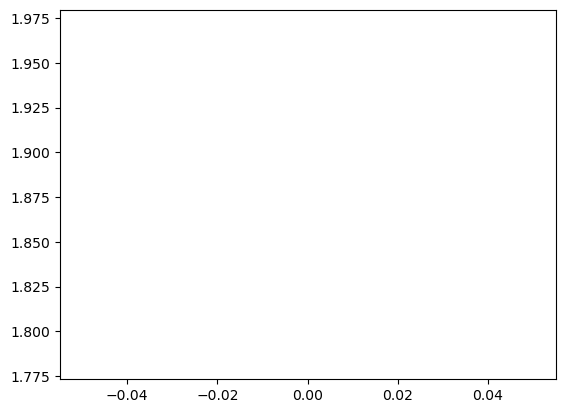

In [38]:
plt.plot(train_losses)
plt.show()

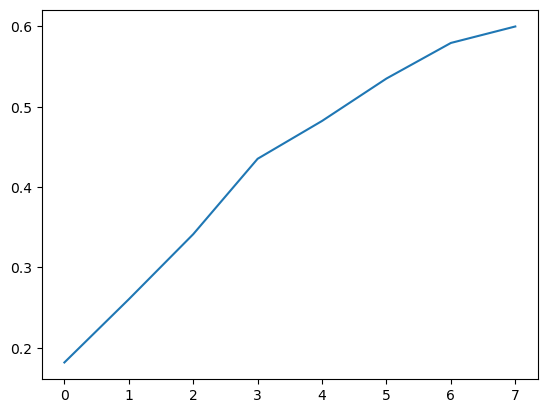

In [22]:
plt.plot(eval_acc)
plt.show()